# Sample Analysis with Example Data

## Introduction

In this analysis, we look at the shift data of ice hockey players using sample data from an event export from the provider Kinexon to gain insights into players' game strategies and performance. 

By examining shift lengths, intensities and pauses between shifts, we can evaluate players' endurance and effectiveness throughout the game. The use of `utils.py` allows us to efficiently process and visualize data.

The aim of this notebook is to give potential users of the algorithm an insight into the type of analyses performed and the resulting findings.

## 1. Data Loading

First, we load the shift data with the `read_file` function. This function extracts the relevant information from the exported event data and prepares it for analysis.

In [1]:
%load_ext autoreload
%autoreload 2

# Zugriff auf die Funktionen in utils.py
import utils

# import der notwendigen Funktionen für Data Loading
from utils import read_file

In [2]:
# Definieren des Dateipfads und des Event-Typs
file_name = 'data/Events-Match_Test__TEAM_A_vs__TEAM_B-Period_Period_1_Period_Period_2_Period_Period_3.csv'
event_type = 'Shifts'

# Laden der Daten mit der read_file Funktion aus utils.py
df = read_file(file_name, event_type)

# Anzeigen der ersten Zeilen des DataFrame zur Überprüfung
df.head()

,Timestamp (ms),Timestamp in local format,Player ID,Name,Event type,Duration (s),Distance,Distance (speed | Very low),Distance (speed | Low),Distance (speed | Medium),Distance (speed | High),Distance (speed | Very high),Distance (speed | Sprint),Distance (speed | 0 - 0 km/h),Metabolic Power (Ø),Speed (max.),Skating Load,Skating Intensity
0,1670697995000,12/10/2022;07:46:35.000 PM,438,D TEST,Shift,34.707001,114.0,29.0,15,25,36,9,0.0,NaN,337.08,22.60,21.67,37.45
1,1670697995000,12/10/2022;07:46:35.000 PM,443,D TEST,Shift,43.952999,177.0,25.0,21,39,51,36,4.0,NaN,413.47,24.34,28.74,39.24
4,1670697995000,12/10/2022;07:46:35.000 PM,470,D3 Guest,Shift,82.765999,288.0,45.0,83,70,87,3,0.0,NaN,0.00,21.88,51.74,37.51
7,1670697995000,12/10/2022;07:46:35.000 PM,471,D4 Guest,Shift,57.615002,215.0,34.0,29,59,79,14,0.0,NaN,0.00,21.75,46.27,48.18
11,1670697995000,12/10/2022;07:46:35.000 PM,448,FW TEST,Shift,20.010000,1.0,1.0,0,0,0,0,0.0,NaN,9.93,4.64,0.49,1.47


## 2. Shift Analysis

Now that we have gained an overview of the shift data, the next step is to go deeper into the analysis of shifts. 

This chapter focuses on the detailed examination of the shifts, starting with determining the optimal number of shifts per player (see 2.1). Identifying the optimal number of shifts is a crucial step in effectively segmenting the data and gaining precise insights into game strategies.

The subsequent analysis of shift length, time between shifts and intensity of individual shifts using visualizations allows us to understand the stress and performance of players during the game (see 2.2).

### 2.1 Optimal Number of Shifts

To analyze the shifts effectively, we first need to determine the optimal number of shifts. The `find_optimal_amount_of_shifts` function uses either a combination of the Elbow method and K-Means clustering to determine the ideal number of clusters for our shift data, or a simple method based on the number of players. The latter method usually works better, as we will see later (see 2.2.2).

In [3]:
from utils import find_optimal_amount_of_shifts

# Bestimmen der optimalen Anzahl von Shifts
optimal_shifts, _ = find_optimal_amount_of_shifts(df, simple=True, verbose=False)
print(f"Optimale Anzahl von Shifts - simple: {optimal_shifts}")

optimal_shifts, _ = find_optimal_amount_of_shifts(df, simple=False, verbose=False)
print(f"Optimale Anzahl von Shifts - elbow: {optimal_shifts}")

Optimale Anzahl von Shifts - simple: 143
Optimale Anzahl von Shifts - elbow: 90


### 2.2 Shift Intensity

#### 2.2.1 Preparation of the Data Frame

Before we start the visualization, we need to make sure that the dataframe contains all the necessary information. This includes the `Player ID`, the `Timestamp (ms)` for each shift, the `Duration (s)` of the shifts and the corresponding `Skating Intensity`.

In addition, the goalkeepers should be removed, as they do not belong to any shift.

Finally, only one team is considered in order to keep the visualization clear.

In [4]:
# Check for required columns
if not {"Timestamp (ms)", "Duration (s)", "Player ID", "Skating Intensity"}.issubset(df.columns):
    raise ValueError("The DataFrame does not contain the necessary columns for visualization.")
else:
    print("All required columns are present in the DataFrame.")
    
# Remove goalkeepers    
df = df[~df["Name"].str.contains("Goalkeeper")]

# Choose team
df_guest = df[df["Name"].str.contains("Guest")]

All required columns are present in the DataFrame.


In this analysis, we focus on the shift intensities of the **guest team**. Of course, the following visualizations can also be used for the home team.

#### 2.2.2 Visualization of the Shift Intensity

With the function `plot_shifts_with_intensity` we create a visualization that shows the shifts of all players together with the intensity of each individual shift. The `get_colour` function is used to color code the intensity of the shifts, which helps us to visually capture the physical load of the players.

This visualization helps us to identify patterns in player shifts and their impact on game intensity.

Shift Intensities using simple method


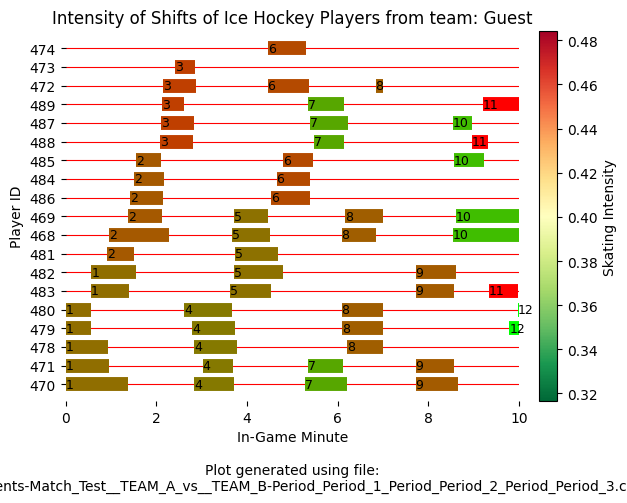

Shift Intensities using elbow method


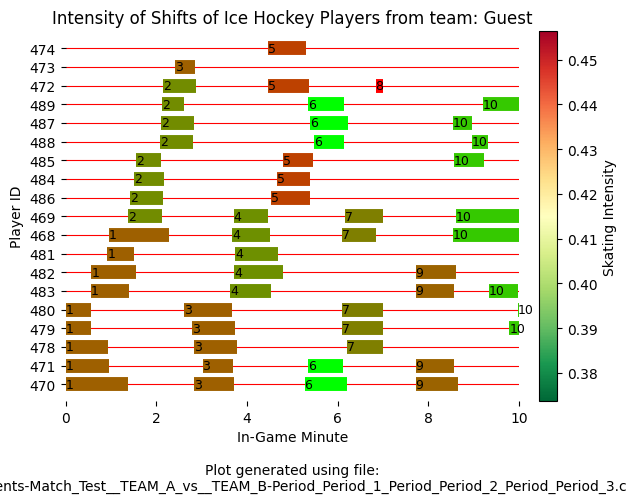

In [5]:
from utils import generate_block_config, plot_shifts_with_intensity

# Generieren der Block-Konfiguration für die Visualisierung
block_config = generate_block_config(
    naive=True,  # Oder False, je nach Analyse
    verbose=False,
    team_name="Guest",
    file_name_raw_data=file_name,
    file_name_save_plot=None  # Optional
)

# Erstellen der Visualisierung mit der naiven Methode
print("Shift Intensities using simple method")
df_guest_intensities = plot_shifts_with_intensity(
    df_guest, 
    block_config,
    time_window_start=0,  # Startzeit in Spielminuten
    time_window_duration=10,  # Dauer des zu visualisierenden Fensters in Minuten
    intensity_indicator="Skating Intensity"  # Die genaue Spalte in deinem df
)

# Zum Vergleich, die Shifts mit der elbow-method
print("Shift Intensities using elbow method")
block_config[utils.BLOCK_CONFIG_NOF_SHIFTS_DESCRIPTOR] = False
_ = plot_shifts_with_intensity(
    df_guest, 
    block_config,
    time_window_start=0,  # Startzeit in Spielminuten
    time_window_duration=10,  # Dauer des zu visualisierenden Fensters in Minuten
    intensity_indicator="Skating Intensity"  # Die genaue Spalte in deinem df
)


As can be seen in the two graphics, the "simple" method (upper graphic) for recognizing shifts delivers better results. While this method identifies the correct 5 players per shift with a few exceptions, the elbow method has more difficulties in identifying 'flying' shifts as shift changes (e.g. shift 1 in the lower graphic contains 9 players). This is due to the fact that the "elbow" method normally calculates a lower optimal number of shifts (see 2.1)

#### 2.2.3 Shift Intensity Score (SIS)

The intensity of each shift provides valuable insights into the effort, performance and stress of the players during their shift. To quantify this intensity and compare it between players, we calculate a **SIS** for each player using `add_sis_column`. This score indicates the intensity of a player's use compared to the average of all players.

To calculate the **SIS**, we first determine the average intensity of each player's bets. Then, we calculate the average intensity of all of a player's assignments. Next, we determine the average intensity of all the players' efforts. Finally, we divide the average intensity of a player by the total average intensity to get the **SIS**.

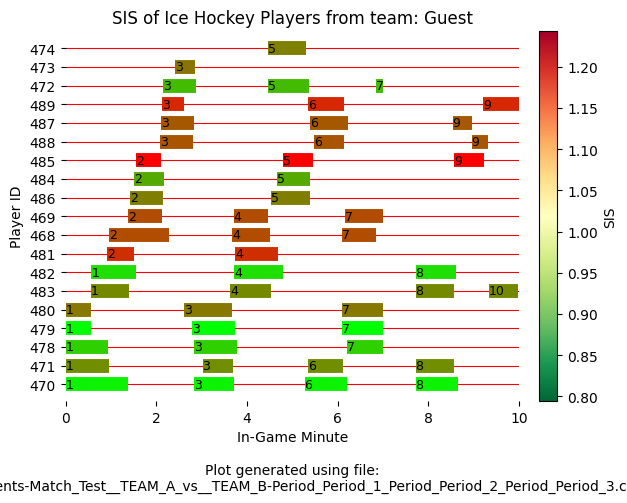

In [6]:
from utils import add_sis_column, plot_SIS

# Berechnung des Shift Intensity Score (SIS) für jeden Spieler
df_with_sis = add_sis_column(df)

# Optional: Anzeigen der ersten Zeilen des angereicherten DataFrames zur Überprüfung
# print(df_with_sis.head())

# Plot SIS
plot_SIS(df_with_sis,
         0,
         10,
         team_name="Guest",
         file_name_raw_data=file_name
         )

The intensity of the shifts for the individual players can also be visualized at player level using the `plot_skating_intensity` function. The shifts per player are displayed over time.

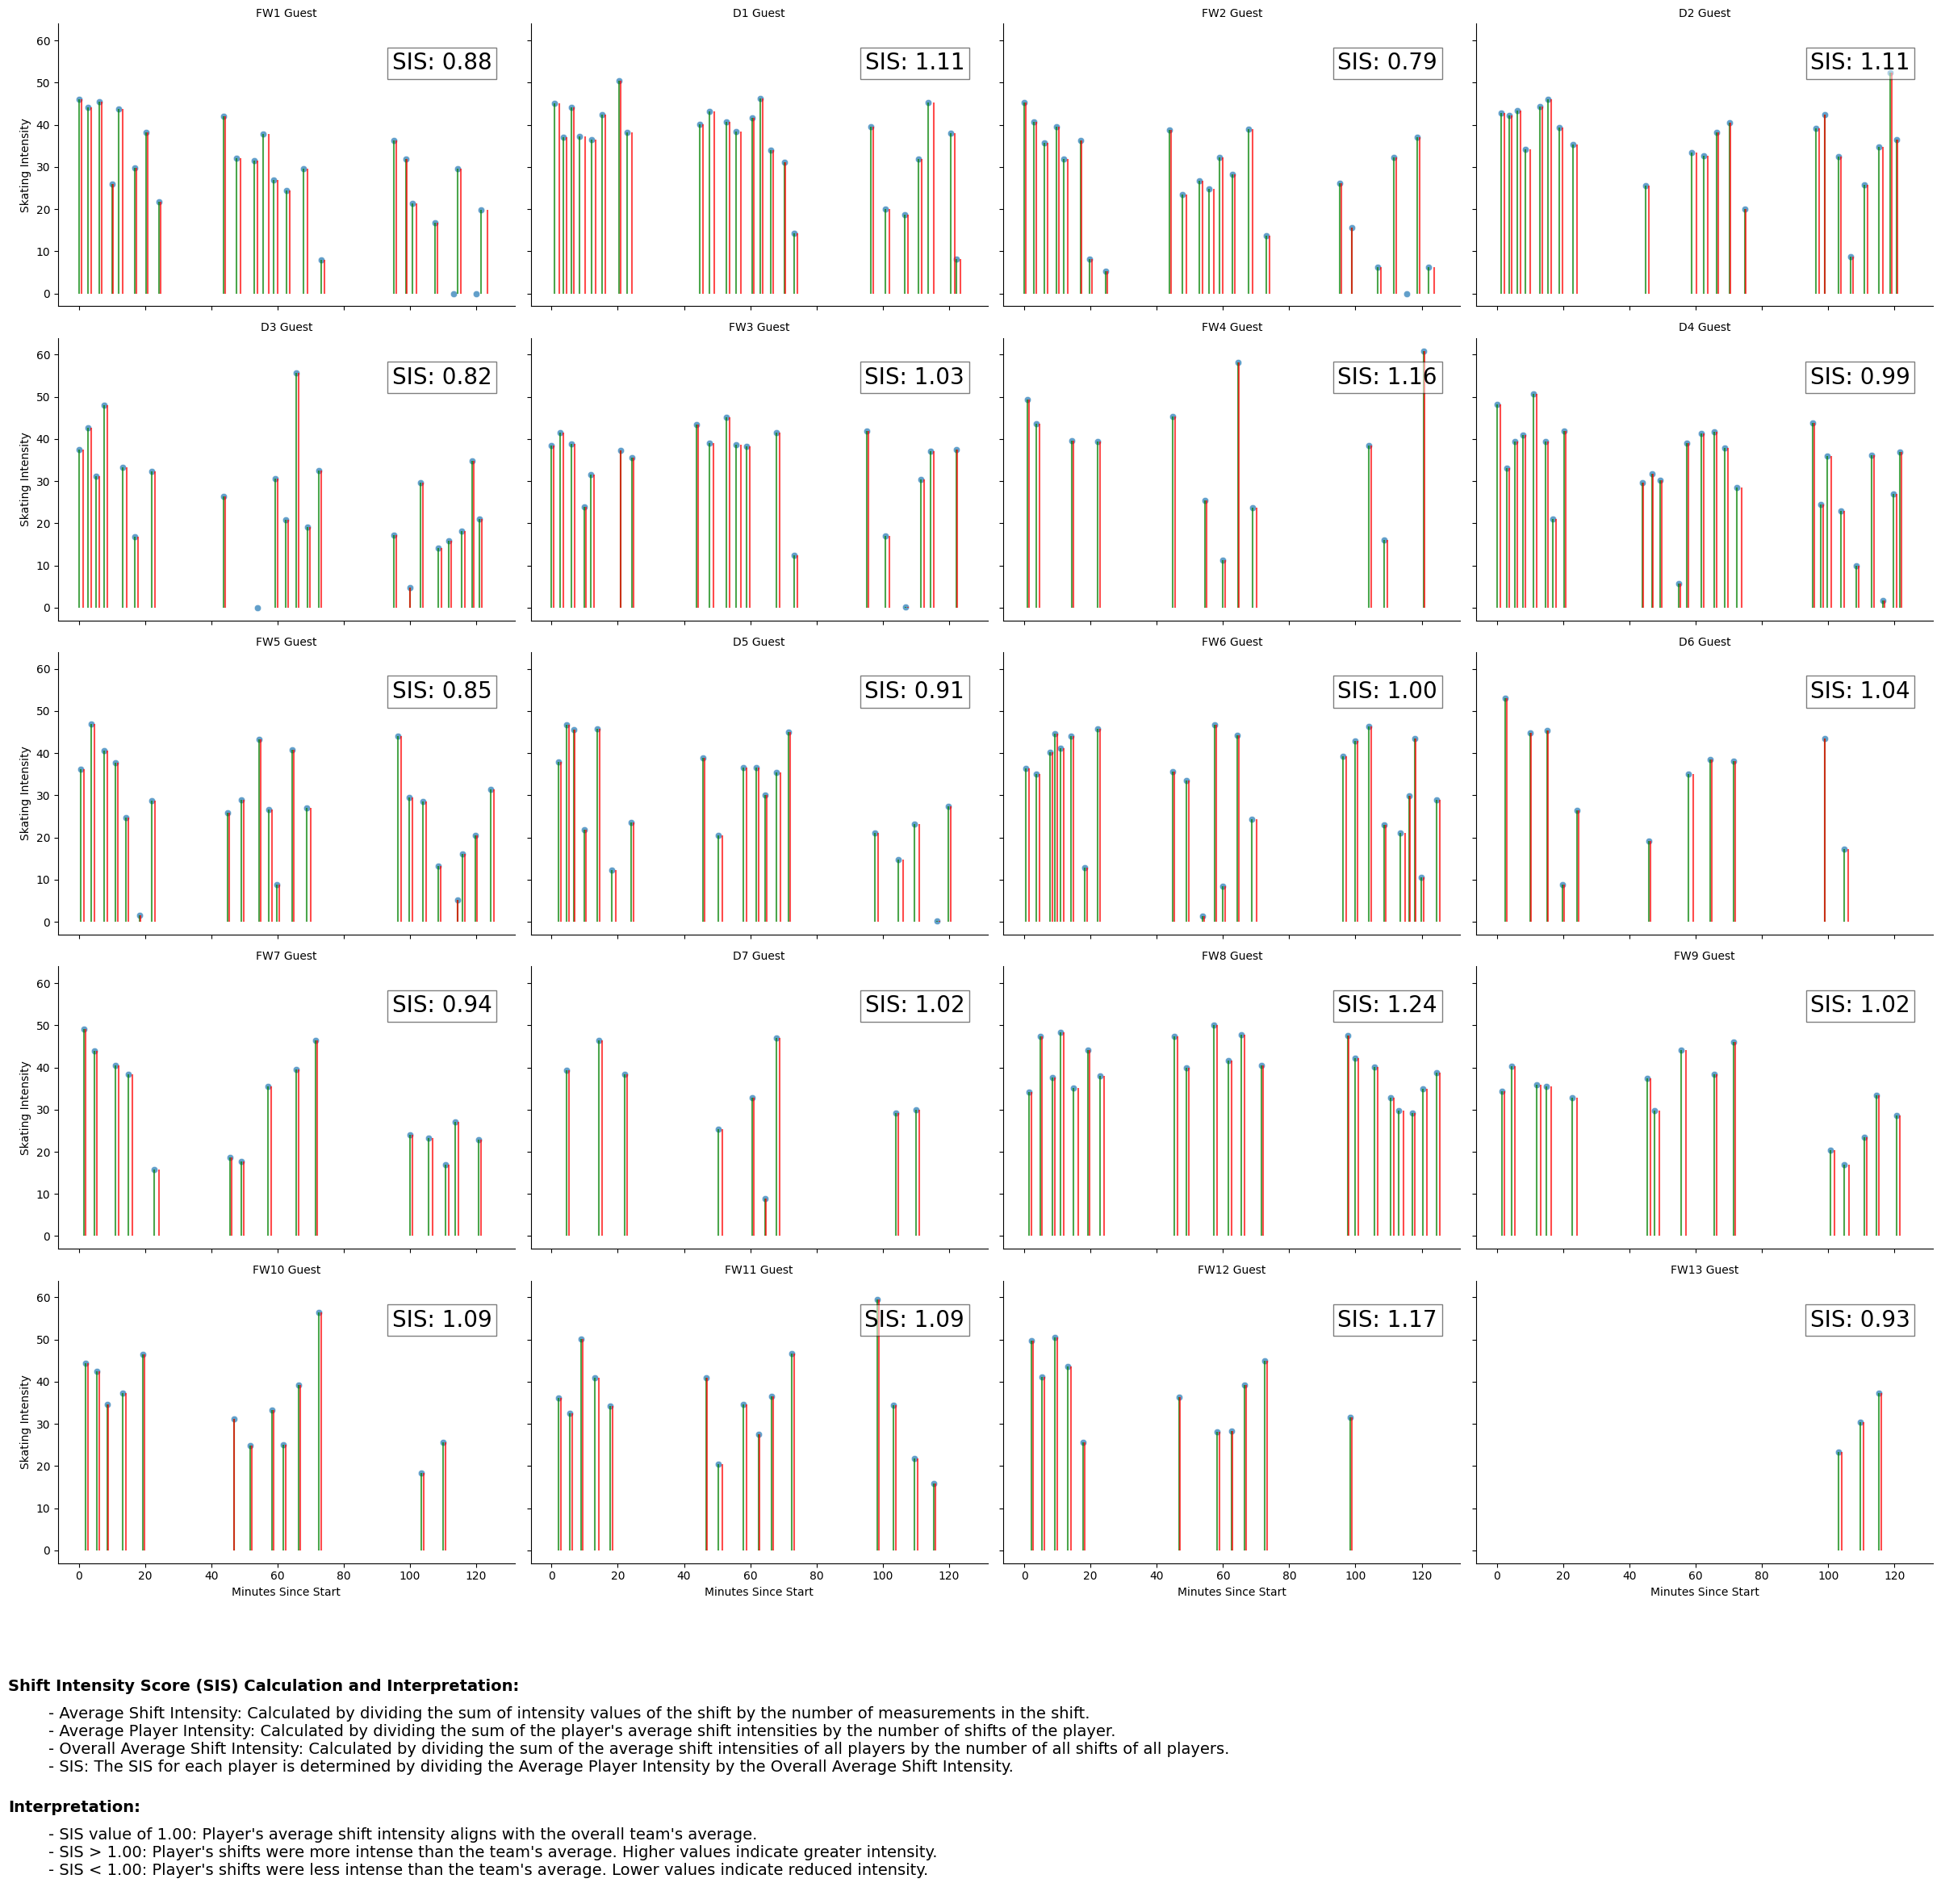

In [7]:
from utils import plot_skating_intensity

# Player selection 
players_guest = df_with_sis[df_with_sis['Name'].str.contains("Guest")]['Name'].unique().tolist()

plot_skating_intensity(df_with_sis, players_guest, 0, 130)


## Conclusion and Outlook

The analysis of shift data provides valuable insights into the physical performance and strategic approach of players in ice hockey. By applying functions from `utils.py`, the data can be efficiently loaded, processed and visualized. Future studies could incorporate additional metrics and phases of play to make the analysis even more detailed.